Q1


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Part1

In [2]:
# ResNet-50

# Load the ResNet Model
# Weights are according to ImageNet dataset
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(DEVICE)

# Put Models in eval mode
# We don't want dropouts to change Feature Maps every run!
resnet_model.eval()

# Preprocessing according to ImageNet dataset
imagenet_preprocess_pipeline = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def load_image(path):
    """
    Load the Image and Preprocess it
    Returns:
        img, img_tensor
        img -> RGB Image
        img_tensor -> Preprocessing Image Tensor    
    """

    img = Image.open(path).convert("RGB")
    img_tensor = imagenet_preprocess_pipeline(img).unsqueeze(0).to(DEVICE)
    return img, img_tensor

def plot_grid(A, channels, title):
    """
    A: numpy array shape (C,H,W)
    channels: list of indices
    """
    fig, axes = plt.subplots(4,4, figsize=(7,7))
    for i, ax in enumerate(axes.flat):
        ch = channels[i]
        fmap_ch = A[ch]
        fmap_ch = (fmap_ch - fmap_ch.min()) / (fmap_ch.max() - fmap_ch.min() + 1e-8)
        ax.imshow(fmap_ch, cmap='viridis')
        ax.set_title(f"ch {ch}", fontsize=8)
        ax.axis('off')
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/swooshie/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.7MB/s]


In [3]:
def get_activation(model, layer):
    fmap = {}
    def hook(m, i, o):
        fmap['value'] = o.detach()
    h = layer.register_forward_hook(hook)
    return fmap, h


def gradcam_per_channel(model, layer, img_tensor, img_original, title="Grad-CAM per-channel"):
    fmap, grads = {}, {}

    def fwd_hook(m, i, o): fmap["value"] = o.detach()
    def bwd_hook(m, gin, gout): grads["value"] = gout[0].detach()

    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_backward_hook(bwd_hook)

    # forward
    out = model(img_tensor)
    pred_class = out.argmax(dim=1).item()

    # backward
    model.zero_grad()
    out[0, pred_class].backward()

    # extract
    A = fmap["value"][0]    # (C, H, W)
    G = grads["value"][0]   # (C, H, W)

    # importance weights
    alpha = G.mean(dim=(1,2))   # shape (C,)

    # pick 16 channels
    topk = alpha.topk(16).indices.cpu().numpy()

    img_np = np.array(img_original).astype(np.float32)/255.
    H, W = img_original.size[1], img_original.size[0]

    # 4x4 grid
    fig, axes = plt.subplots(4,4, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        ch = int(topk[i])
        
        cam = torch.relu(alpha[ch] * A[ch]).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        cam_resized = cv2.resize(cam, (W, H))
        heatmap = plt.cm.jet(cam_resized)[:, :, :3]
        overlay = np.clip(0.4*heatmap + 0.6*img_np, 0, 1)

        ax.imshow(overlay)
        ax.set_title(f"ch {ch}")
        ax.axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    h1.remove()
    h2.remove()



def visualize_layer(model, layer, img, img_tensor, layer_name, image_name):
    fmap, handle = get_activation(model, layer)
    _ = model(img_tensor)           # forward pass
    handle.remove()
    
    A = fmap["value"][0].cpu().numpy()   # C,H,W
    C = A.shape[0]
    
    # Pick 16 channels evenly spaced
    channels = np.linspace(0, C-1, 16, dtype=int)
    
    title = f"ResNet50 — {image_name} — {layer_name}"
    plot_grid(A, channels, title)

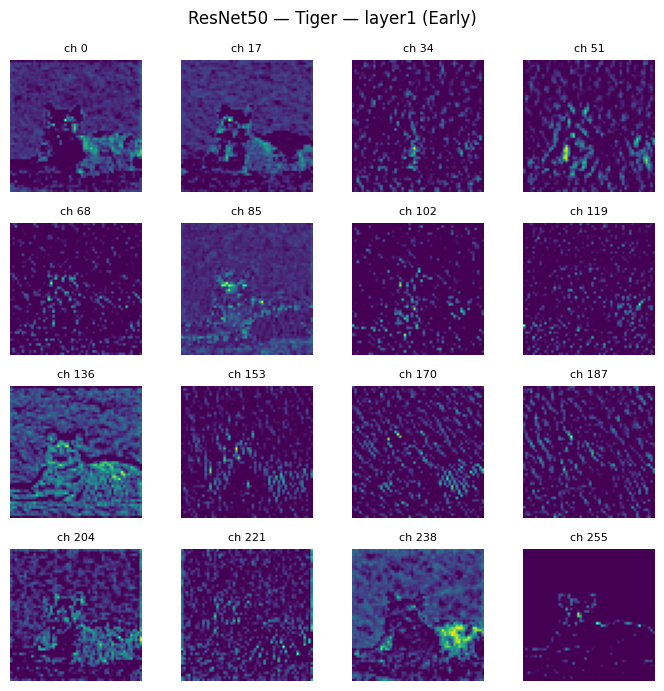

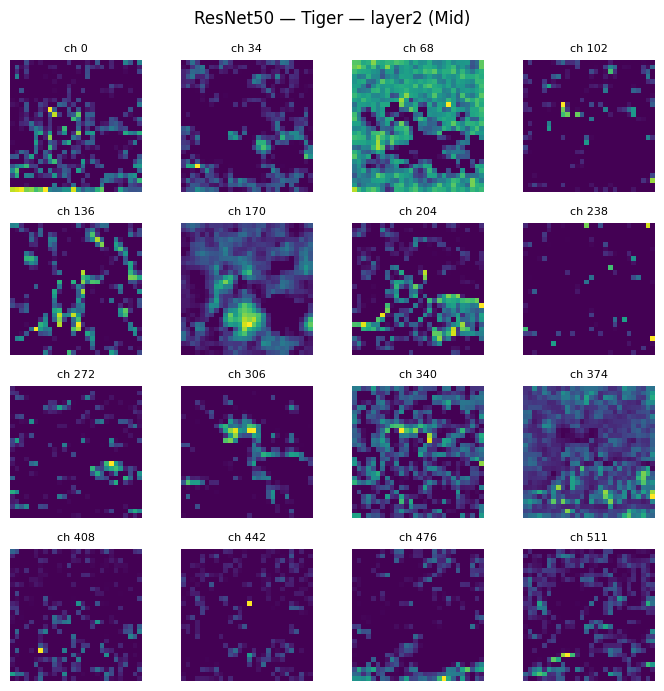

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


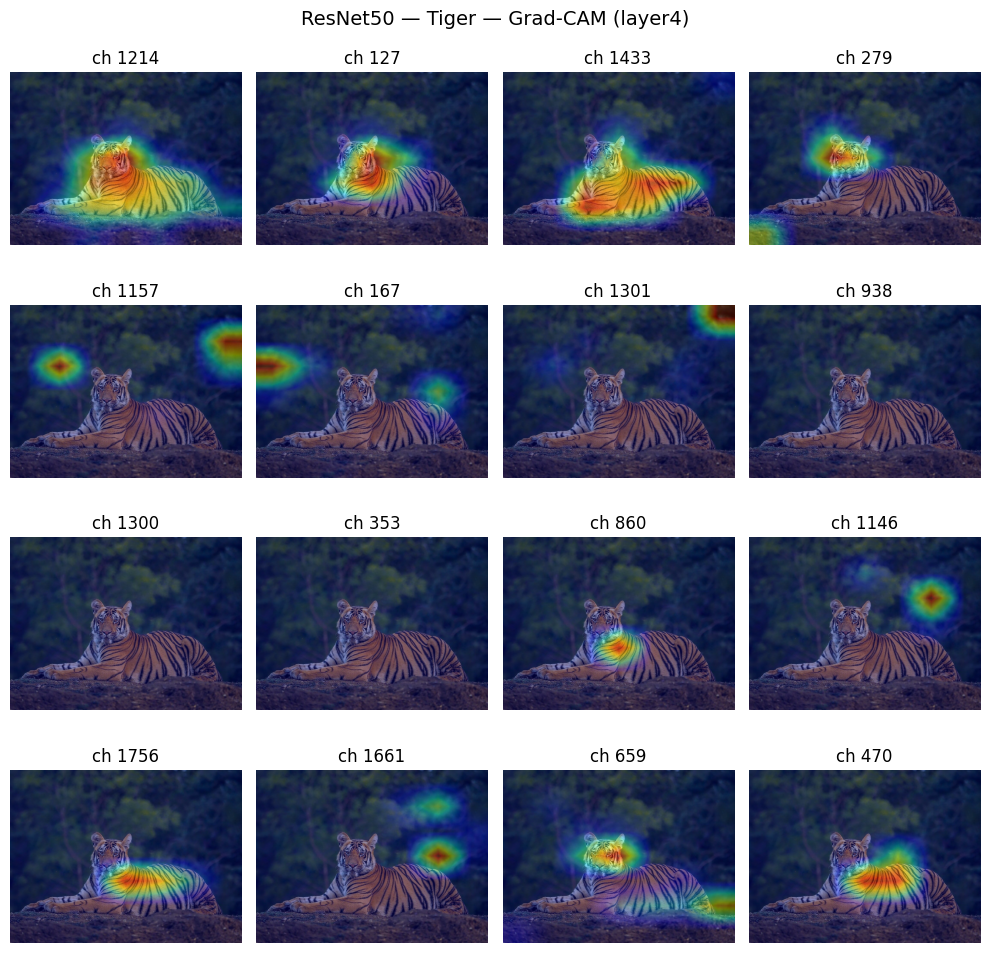

In [5]:

early_layer = resnet_model.layer1        # early features
mid_layer   = resnet_model.layer2        # mid-level features
deep_layer  = resnet_model.layer4        # final conv block (use Grad-CAM)

tiger_img, tiger_tensor = load_image("data/Question1/Royal-Bengal-Tiger.jpg")
face_img, face_tensor = load_image("data/Question1/face.png")

# Early
visualize_layer(resnet_model, early_layer, tiger_img, tiger_tensor, "layer1 (Early)", "Tiger")

# Mid
visualize_layer(resnet_model, mid_layer, tiger_img, tiger_tensor, "layer2 (Mid)", "Tiger")

# Deep activations may look messy -> use Grad-CAM
gradcam_per_channel(resnet_model, deep_layer, tiger_tensor, tiger_img, "ResNet50 — Tiger — Grad-CAM (layer4)")


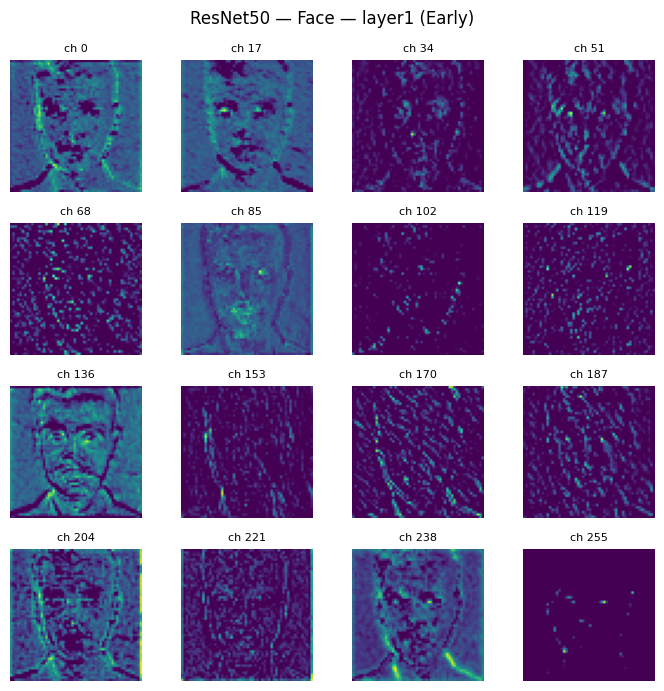

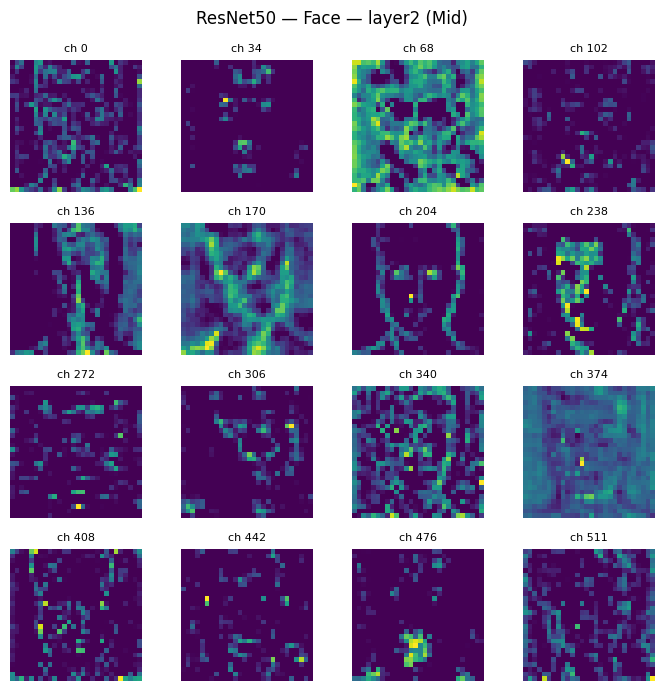

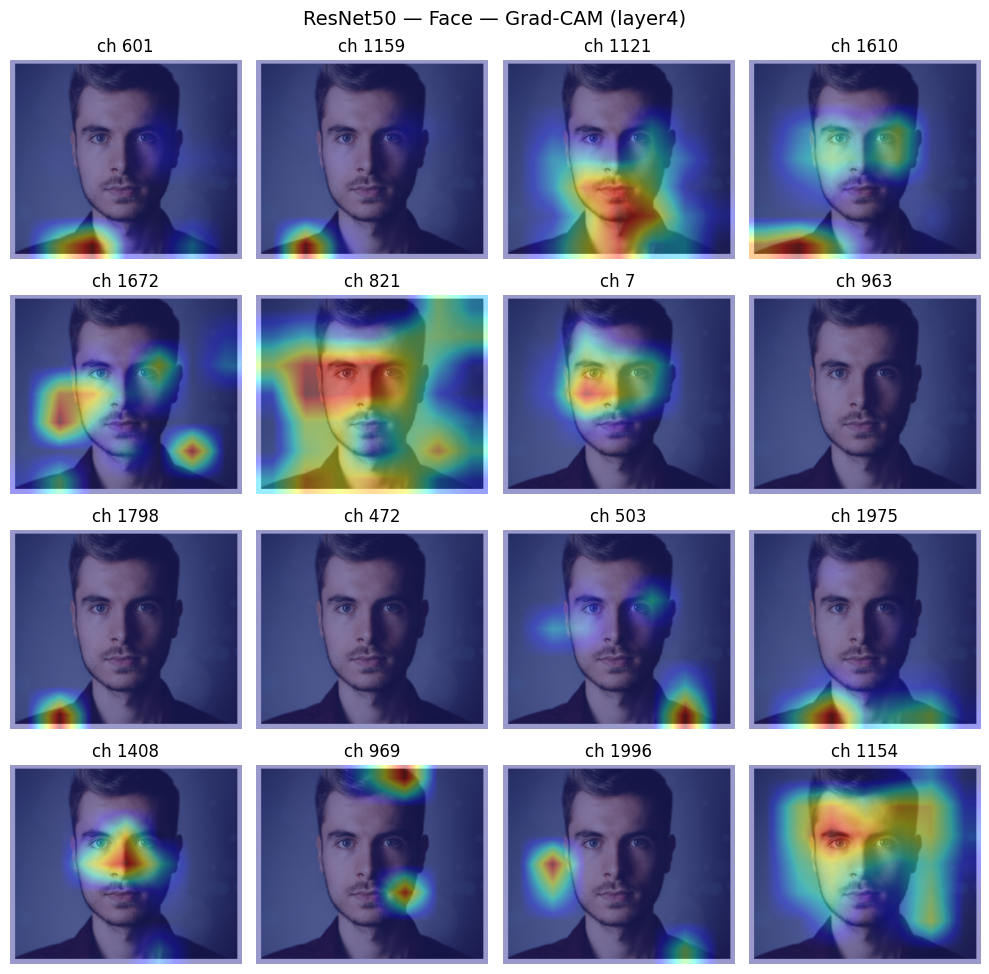

In [6]:
# Early
visualize_layer(resnet_model, early_layer, face_img, face_tensor, "layer1 (Early)", "Face")

# Mid
visualize_layer(resnet_model, mid_layer, face_img, face_tensor, "layer2 (Mid)", "Face")

# Deep -> Grad-CAM
gradcam_per_channel(resnet_model, deep_layer, face_tensor, face_img, "ResNet50 — Face — Grad-CAM (layer4)")


Part2

In [7]:
densenet_model = models.densenet121(weights="DEFAULT").to(DEVICE)
densenet_model.eval()


early_block = densenet_model.features.denseblock1
mid_block   = densenet_model.features.denseblock2   # or denseblock3
deep_block  = densenet_model.features.denseblock4

In [8]:
def plot_densenet_feature_grid(A, title="Feature Maps", num_channels=16):
    """
    A: torch tensor (C,H,W)
    Plots first `num_channels` channels in 4x4 grid
    """
    grid_rows, grid_cols = 4, 4
    plt.figure(figsize=(10,10))
    for i in range(num_channels):
        fmap = A[i].cpu().numpy()
        fmap -= fmap.min()
        fmap /= (fmap.max() + 1e-6)
        plt.subplot(grid_rows, grid_cols, i+1)
        plt.imshow(fmap, cmap="viridis")
        plt.title(f"ch {i}", fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_densenet_activations(model, layer):
    fmap = {}
    def hook(m, i, o):
        fmap['value'] = o.detach()
    handle = layer.register_forward_hook(hook)
    return fmap, handle

def gradcam_denseblock(model, layer, img_tensor, img_original, top_k=16, title="Grad-CAM per-channel"):
    fmap, grads = {}, {}

    def fwd_hook(m, i, o): fmap["value"] = o.detach()
    def bwd_hook(m, gin, gout): grads["value"] = gout[0].detach()

    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_backward_hook(bwd_hook)

    out = model(img_tensor)
    pred_class = out.argmax(dim=1).item()
    model.zero_grad()
    out[0, pred_class].backward()

    A = fmap["value"][0]   # (C,H,W)
    G = grads["value"][0]

    alpha = G.mean(dim=(1,2))   # channel importance
    top_channels = alpha.topk(top_k).indices.cpu().numpy()

    img_np = np.array(img_original).astype(np.float32) / 255.0
    H, W = img_original.size[1], img_original.size[0]

    plt.figure(figsize=(12,12))
    for idx, ch in enumerate(top_channels):
        cam = torch.relu(alpha[ch] * A[ch]).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-6)
        cam_resized = cv2.resize(cam, (W,H))
        heatmap = plt.cm.jet(cam_resized)[:,:,:3]
        overlay = np.clip(0.4*heatmap + 0.6*img_np, 0, 1)

        plt.subplot(4,4,idx+1)
        plt.imshow(overlay)
        plt.title(f"ch {ch}", fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    h1.remove(); h2.remove()



In [9]:
tiger_input_tensor = imagenet_preprocess_pipeline(tiger_img).unsqueeze(0).to(DEVICE)
face_input_tensor = imagenet_preprocess_pipeline(face_img).unsqueeze(0).to(DEVICE)

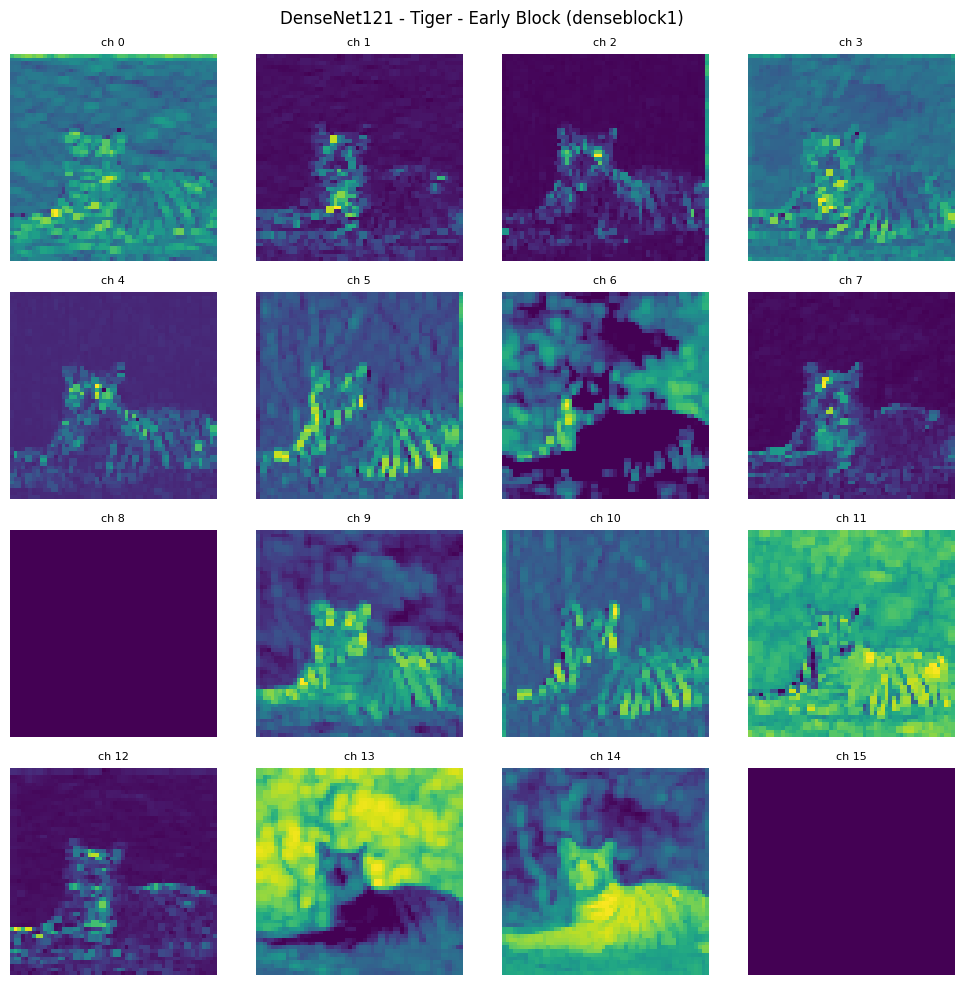

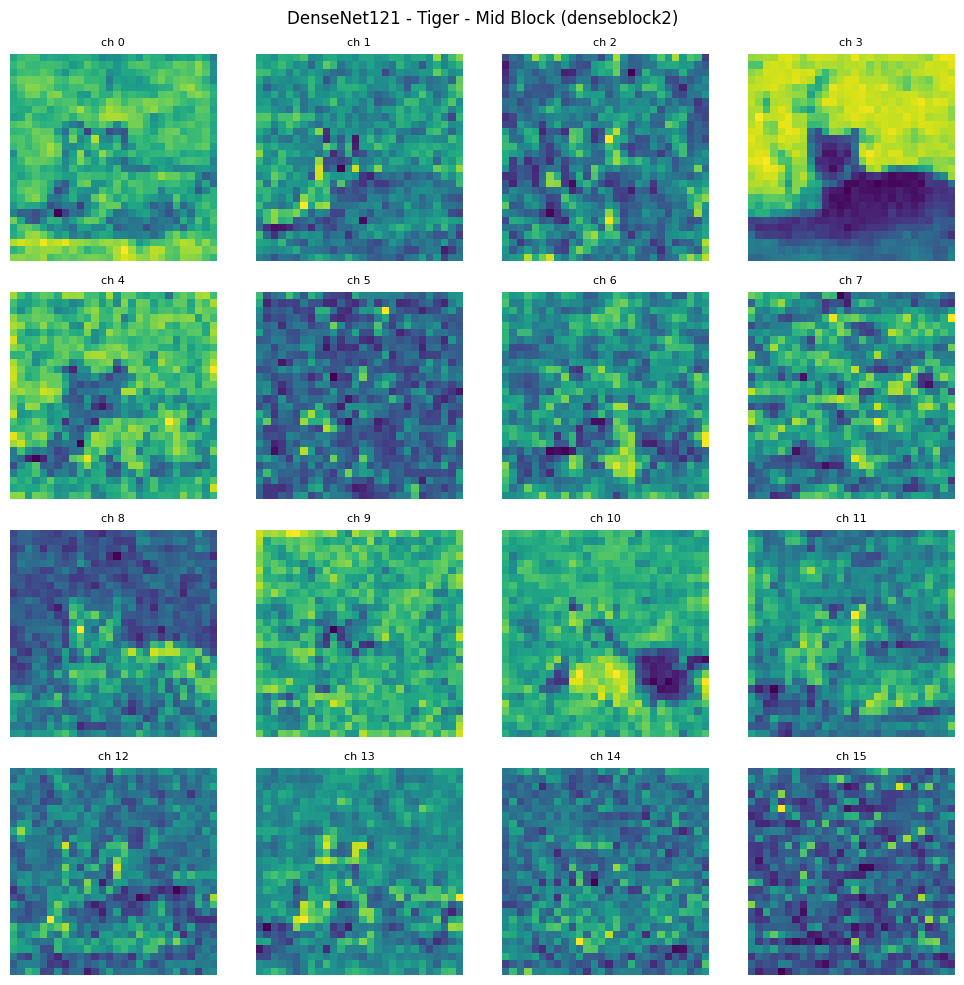

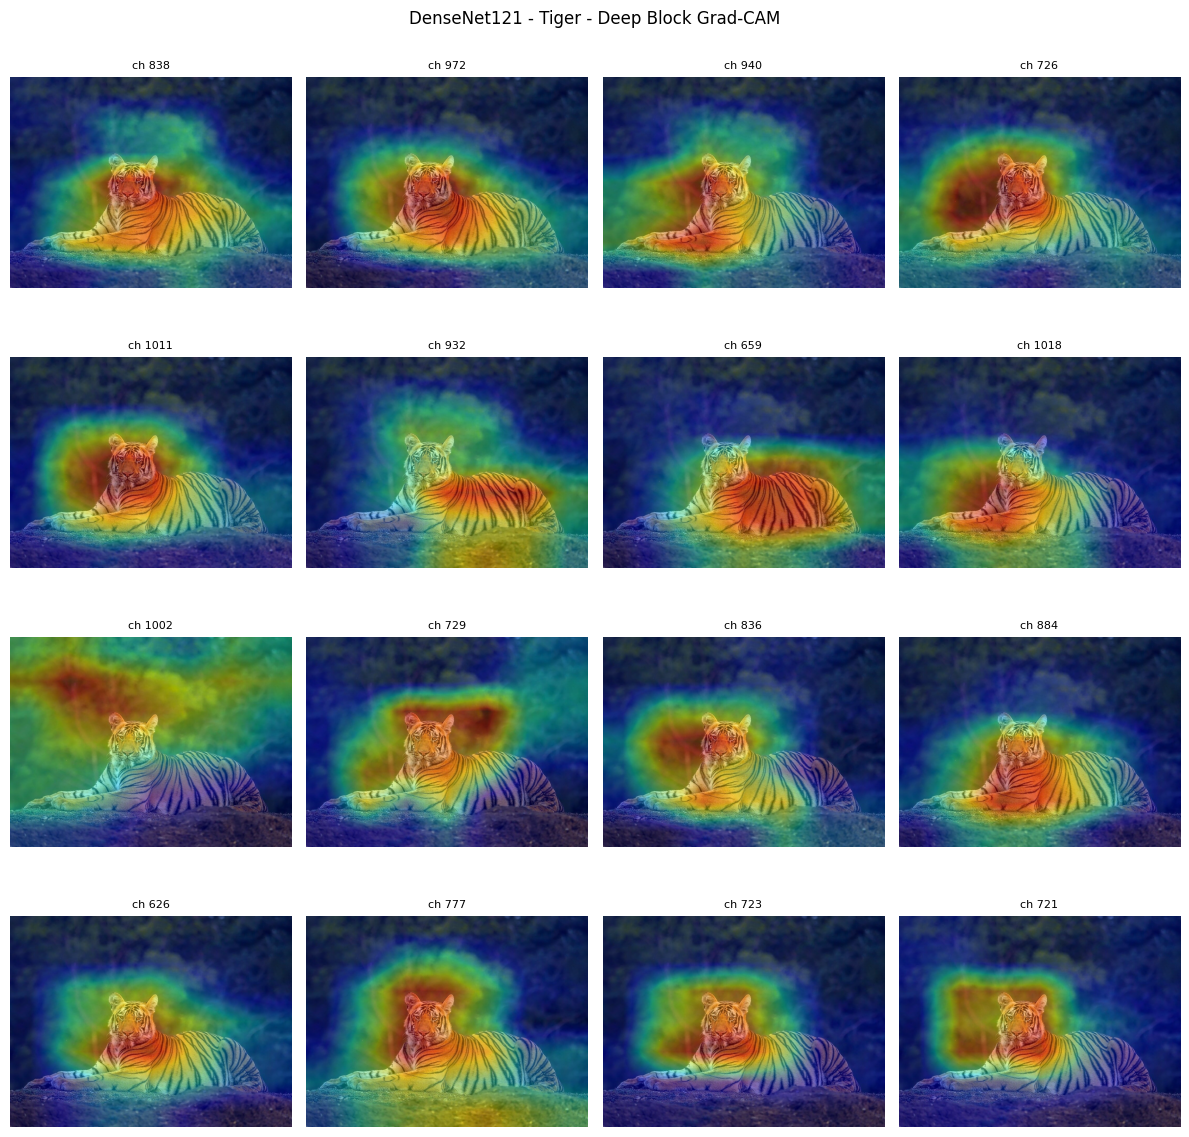

In [10]:
# Early block feature maps
fmap, handle = get_densenet_activations(densenet_model, early_block)
_ = densenet_model(tiger_input_tensor)
plot_densenet_feature_grid(fmap["value"][0], title="DenseNet121 - Tiger - Early Block (denseblock1)")
handle.remove()

# Mid block feature maps
fmap, handle = get_densenet_activations(densenet_model, mid_block)
_ = densenet_model(tiger_input_tensor)
plot_densenet_feature_grid(fmap["value"][0], title="DenseNet121 - Tiger - Mid Block (denseblock2)")
handle.remove()

# Deep block Grad-CAM (16 channels)
gradcam_denseblock(densenet_model, deep_block, tiger_input_tensor, tiger_img,
                   top_k=16, title="DenseNet121 - Tiger - Deep Block Grad-CAM")


In [ ]:
# Early block
fmap, handle = get_densenet_activations(densenet_model, early_block)
_ = densenet_model(face_input_tensor)
plot_densenet_feature_grid(fmap["value"][0], title="DenseNet121 - Face - Early Block (denseblock1)")
handle.remove()

# Mid block
fmap, handle = get_densenet_activations(densenet_model, mid_block)
_ = densenet_model(face_input_tensor)
plot_densenet_feature_grid(fmap["value"][0], title="DenseNet121 - Face - Mid Block (denseblock2)")
handle.remove()

# Deep block Grad-CAM
gradcam_denseblock(densenet_model, deep_block, face_input_tensor, face_img,
                   top_k=16, title="DenseNet121 - Face - Deep Block Grad-CAM")


Part3

In [ ]:
# Analysis and Comparisons

def q1_gradcam_last_layer(model, target_layer, img_tensor, img_original):
    """
    Compute Grad-CAM for the last conv/dense block of a model.

    Args:
        model: pretrained model (ResNet50/DenseNet121)
        target_layer: last layer to hook (layer4/denseblock4)
        img_tensor: preprocessed input tensor (1,C,H,W)
        img_original: original PIL image
    """
    fmap, grads = {}, {}

    # Define Hooks
    def fwd_hook(m, i, o): fmap["value"] = o.detach()
    def bwd_hook(m, gin, gout): grads["value"] = gout[0].detach()

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    # Forward pass
    out = model(img_tensor)
    pred_class = out.argmax(dim=1).item()
    model.zero_grad()

    # Backward pass
    out[0, pred_class].backward()

    # Grad-CAM computation
    A = fmap["value"][0]  # (C,H,W)
    G = grads["value"][0] # (C,H,W)

    alpha = G.mean(dim=(1,2))  # channel weights
    cam = torch.relu((alpha[:, None, None] * A).sum(dim=0))
    cam = (cam - cam.min()) / (cam.max() + 1e-6)

    # Resize to original image size
    H, W = img_original.size[1], img_original.size[0]
    cam_resized = cv2.resize(cam.cpu().numpy(), (W,H))

    # Create heatmap overlay
    heatmap = plt.cm.jet(cam_resized)[:,:,:3]
    img_np = np.array(img_original).astype(np.float32)/255.
    overlay = np.clip(0.4*heatmap + 0.6*img_np, 0, 1)

    # Remove hooks
    h1.remove()
    h2.remove()

    return overlay

def q1_analysis_and_comparison(img_input_tensor, input_img):
    activations = {}

    def hook_fn(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu()
        return hook

    # Get Entire Pretrained Model: ResNet50
    resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(DEVICE)
    resnet_model.eval()

    # Extract Output of Each Channel
    getattr(resnet_model, "layer1").register_forward_hook(hook_fn("layer1"))
    getattr(resnet_model, "layer2").register_forward_hook(hook_fn("layer2"))
    getattr(resnet_model, "layer4").register_forward_hook(hook_fn("layer4"))


    # Get Entire Pretrained Model: DenseNet121
    densenet_model = models.densenet121(weights="DEFAULT").to(DEVICE)
    densenet_model.eval()
    
    # Extract Output of Each Block
    getattr(densenet_model.features, "denseblock1").register_forward_hook(hook_fn("denseblock1"))
    getattr(densenet_model.features, "denseblock2").register_forward_hook(hook_fn("denseblock2"))
    getattr(densenet_model.features, "denseblock4").register_forward_hook(hook_fn("denseblock4"))
    
    with torch.no_grad():
        _ = resnet_model(img_input_tensor)
        _ = densenet_model(img_input_tensor)
    
    # Extract Focus of the Layer
    def l2_norm_map(A):
        return torch.sqrt((A**2).sum(dim=1))[0].numpy()

    grid_rows, grid_cols = 2, 3
    plt.figure(figsize=(10,10))
    for i, layer_name in enumerate(["layer1", "layer2", "layer4", "denseblock1", "denseblock2", "denseblock4"]):
        fmap = activations[layer_name]
        fmap -= fmap.min()
        fmap /= (fmap.max() + 1e-6)

        plt.subplot(grid_rows, grid_cols, i+1)

        if layer_name == "layer4" or layer_name == "denseblock4":
            overlay = None
            if layer_name == "layer4":
                overlay = q1_gradcam_last_layer(resnet_model, resnet_model.layer4, img_input_tensor, input_img)
            else:
                overlay = q1_gradcam_last_layer(densenet_model, densenet_model.features.denseblock4, img_input_tensor, input_img)    

            plt.imshow(overlay)
            plt.title(f"Grad-CAM of {layer_name}", fontsize=8)
        else:
            plt.imshow(l2_norm_map(fmap), cmap="jet")
            plt.title(f"{layer_name}", fontsize=8)
            
        plt.axis("off")
        
    plt.suptitle("Analysis of ResNet50 and DenseNet121")
    plt.tight_layout()
    plt.show()


q1_analysis_and_comparison(tiger_input_tensor, tiger_img)
q1_analysis_and_comparison(face_input_tensor, face_img)


## Analysis and Comparison

### **(i) Abstraction**

Deep CNNs transform raw pixels into increasingly abstract concepts as data flows deeper into the network.
Both **ResNet50** and **DenseNet121** show this progression, but in slightly different ways.

#### **ResNet50**

##### **Early layers (layer1)**

* Activations look like **edge detectors, color blobs, and simple textures**.
* Many channels highlight **Gabor-like edges**, corners, and oriented patterns.
* Spatial detail is high (large 56×56 feature maps), so textures and fine boundaries remain visible.

##### **Mid layers (layer2 / layer3)**

* Feature maps become **more complex and less “pixel-like.”**
* Channels detect **object parts** and **mid-level patterns**:
  
  * fur strips for the tiger
  * skin/cheek contours or hair regions for the face
* Representations become **more selective**, with fewer activated regions.

##### **Deep layers (layer4)**

* Spatial resolution is very low (7×7), so maps look **coarse and patch-like**.
* Activations focus on **high-level semantic concepts**:

  * Tiger: head, jawline, or distinctive stripes
  * Face: beard region, eye-socket shadows, or outline of the head
* Raw feature maps appear sparse or uninterpretable, requiring **Grad-CAM** to see what the model emphasizes.

#### **DenseNet121**

DenseNet extracts similar abstractions, but feature evolution differs due to **dense connectivity** (each layer receives all previous feature maps).

##### **Early block (denseblock1)**

* Strong focus on **edges, gradients, and textures**, similar to ResNet.
* But because of feature reuse, early maps often contain **richer textures** than ResNet’s early layers.

##### **Mid block (denseblock2/3)**

* Much denser combination of features.
* Activations show **multiple patterns fused into a single map** because earlier features are concatenated at every layer.
* Channels highlight **part-like structures**:

  * tiger fur clumps
  * facial outline or hair patterns

##### **Deep block (denseblock4, last)**

* Very small maps (7×7), very abstract.
* Individual channels are **highly class-discriminative** and more mixed than ResNet.
* Grad-CAM reveals **semantic focus**, usually on:

  * tiger face/ears/stripe clusters
  * human nose-eye region or chin

> **So, as we move from early -> mid -> deep layers, both ResNet50 and DenseNet121 exhibit a clear abstraction hierarchy. Early layers capture low-level edges and textures; mid layers capture object parts; deep layers encode high-level semantic concepts but have coarse spatial resolution. DenseNet’s mid-level features appear richer and more blended due to dense connectivity, whereas ResNet’s activations appear more isolated and structured across layers.**

## **(ii) Sparsity**

*A sparse activation map = few bright regions → the model fires only on select discriminative areas.*

#### **Which image yields sparser activations?**

**The tiger image produces *sparser* activations than the human face** in both models.

#### **Why?**

* The tiger has **high-contrast, highly discriminative textures** (stripes) that strongly activate only certain channels.
* The face has **smooth gradients** and fewer high-frequency textures, so many channels respond weakly and broadly.

#### **ResNet50 vs DenseNet121**

* **ResNet50** tends to produce **more sparse** maps because each block outputs new features and the residual shortcuts don’t blend everything.
* **DenseNet121** produces **less sparse** maps, especially in mid and deep layers, because of **dense feature reuse**:

  * every layer receives *all* previous feature maps
    → activations contain mixtures of earlier features
    → generally **more channels stay active**.

> The tiger consistently yields sparser activations because its high-contrast stripes activate only specific channels. DenseNet121 shows less sparsity than ResNet50 due to its dense connectivity, which encourages feature reuse and results in more blended activations across layers.

### **(iii) Smoothness / Resolution**

#### **Observation**

As depth increases, feature maps become **more blocky, coarse, and less detailed**.

#### **Why?**

Spatial sizes shrink due to:

* strided convolutions
* pooling (e.g., 224 -> 112 -> 56 -> 28 -> 14 -> 7)

When you reach 7 x 7:

* each cell corresponds to a **large receptive field** (dozens of input pixels)
* small details (eyes, whiskers, wrinkles) cannot be localized
* activations represent **global concepts rather than edges**

#### **Why this is useful**

* Fine spatial detail is lost → less precision
* But high semantic context emerges → stronger classification cues

> Deeper layers have very low spatial resolution (e.g., 7×7), so each activation corresponds to a large portion of the input image. This causes feature maps to appear blocky but allows the network to capture high-level semantic structure rather than local texture.

### **(iv) Semantic focus**

#### **ResNet50**

* **Tiger**: strong focus on the **face/muzzle**, sometimes stripes on forehead.
* **Human face**: focus on **eyes–nose–mouth triangle**, but occasionally shifts to hair/chin depending on lighting and pose.

#### **DenseNet121**

* **Tiger**: similar to ResNet, but often spreads attention more due to feature reuse; includes **ears and upper torso**.
* **Human face**: emphasizes **central facial region**, but sometimes diffuses into hair/background because DenseNet mixes many earlier features.

#### **Difference between the two models**

* ResNet50 has **cleaner, more isolated** attention regions (due to residual structure).
* DenseNet121 often has **more diffuse or blended attention**, because deeper layers receive all previous features.

> Grad-CAM shows that both models emphasize semantically meaningful regions: the tiger’s head and the human facial center. ResNet50 tends to produce more localized attention, whereas DenseNet121 produces more diffused focus due to dense feature reuse. The two networks broadly agree on the most discriminative object parts, but DenseNet spreads its attention over a larger region.

### **(v) Image dependence**

**Which image produces clearer, more meaningful activations?**
→ The **tiger image**.

#### **Why?**

* Tiger stripes create **high-contrast, high-frequency textures**, which CNN filters detect extremely easily.
* The human face has **smooth shading and fewer distinctive textures**, so deep layers produce:

  * less sharp activations
  * more ambiguity
  * sometimes attention shifts to background (hair, shoulder)

#### **Difference between models**

* ResNet50 captures tiger structure particularly well → more clean mid-layer and deep activations.
* DenseNet121 still interprets both images, but its blended features sometimes reduce clarity for the smoother face image.

> The tiger image yields more structured and meaningful deep activations because its rich textures (stripes, contours) align well with CNN filters trained on ImageNet. The human face, having smoother gradients and fewer distinctive textures, produces more diffuse and less interpretable deep-layer maps.


Q2

Part1

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

VIDEO_PATH = "/Users/naman/Downloads/CV Proj 3/Question2/highway.mp4"
FPS = 25.0  # given by the project

In [ ]:
# Load pretrained Faster R-CNN (COCO)
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterrcnn = fasterrcnn_resnet50_fpn(weights=weights).to(device)
fasterrcnn.eval()

# COCO class names for the detector
coco_classes = weights.meta["categories"]

# Transform: OpenCV BGR frame -> normalized tensor for the detector
det_transform = transforms.Compose([
    transforms.ToTensor()  # converts HxWxC in [0,255] to CxHxW in [0,1]
])

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

# Read first frame
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Could not read first frame.")

boxes, labels, scores = detect_vehicles(frame)

vis = frame.copy()
for box, label, sc in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{label} {sc:.2f}"
    cv2.putText(vis, text, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Show with matplotlib (in notebook)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Q2(a) – Vehicle detection example")
plt.show()

Part2

In [ ]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    inter = interW * interH

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter + 1e-6
    return inter / union

In [ ]:
class Track:
    def __init__(self, track_id, box, label, color):
        self.id = track_id
        self.box = box  # [x1,y1,x2,y2]
        self.label = label
        self.color = color
        self.trace = []  # list of (cx, cy)
        self.missed = 0  # how many frames we didn't see it

    def update(self, box):
        self.box = box
        self.missed = 0
        cx = (box[0] + box[2]) / 2.0
        cy = (box[1] + box[3]) / 2.0
        self.trace.append((cx, cy))


next_track_id = 0
tracks = []
MAX_MISSED = 10   # frames before a track is deleted
IOU_THRESH = 0.3  # association threshold

In [ ]:
import random

def update_tracks(boxes, labels):
    """
    Update global `tracks` list based on current detections.
    boxes: list of [x1,y1,x2,y2]
    labels: list of class names
    """
    global next_track_id, tracks

    # Mark all tracks as "unmatched"
    for tr in tracks:
        tr.missed += 1

    # Greedy matching: for each detection, find track with best IoU
    for box, label in zip(boxes, labels):
        best_iou = 0.0
        best_track = None
        for tr in tracks:
            i = iou(box, tr.box)
            if i > best_iou:
                best_iou = i
                best_track = tr

        if best_track is not None and best_iou >= IOU_THRESH:
            best_track.update(box)
        else:
            # create new track
            color = (
                random.randint(0, 255),
                random.randint(0, 255),
                random.randint(0, 255),
            )
            tr = Track(next_track_id, box, label, color)
            tr.update(box)
            tracks.append(tr)
            next_track_id += 1

    # Remove long-missed tracks
    tracks = [tr for tr in tracks if tr.missed <= MAX_MISSED]

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or FPS

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_tracked = cv2.VideoWriter("highway_tracked.mp4", fourcc, fps, (width, height))

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    boxes, labels, scores = detect_vehicles(frame)
    update_tracks(boxes, labels)

    # Draw tracks
    vis = frame.copy()
    for tr in tracks:
        x1, y1, x2, y2 = tr.box
        color = tr.color
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        text = f"ID {tr.id} ({tr.label})"
        cv2.putText(vis, text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # draw trajectory
        for k in range(1, len(tr.trace)):
            x_prev, y_prev = tr.trace[k - 1]
            x_curr, y_curr = tr.trace[k]
            cv2.line(vis,
                     (int(x_prev), int(y_prev)),
                     (int(x_curr), int(y_curr)),
                     color, 2)

    out_tracked.write(vis)
    frame_idx += 1

cap.release()
out_tracked.release()
print("Saved tracking video as highway_tracked.mp4")

In [ ]:
import matplotlib.pyplot as plt

def show_frame_from_video(video_path, frame_number=0, title=""):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Could not open {video_path}"

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_number = min(frame_number, max(0, total_frames - 1))

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise RuntimeError("Could not read frame from video.")

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example: show middle frame of tracking video
show_frame_from_video("highway_tracked.mp4",
                      frame_number=50,
                      title="Q2(b) – Sample tracking frame")

Part3


In [ ]:
def compute_dense_flow(prev_gray, curr_gray):
    """
    Compute dense optical flow between two grayscale frames using Farneback.
    Returns:
        flow: HxWx2 array (dx, dy) per pixel
    """
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, curr_gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    return flow

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or FPS

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_speed = cv2.VideoWriter("highway_speed.mp4", fourcc, fps, (width, height))

# reset tracker
next_track_id = 0
tracks = []

ret, prev_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read video.")

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

frame_idx = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break

    curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = compute_dense_flow(prev_gray, curr_gray)

    # detection + tracking
    boxes, labels, scores = detect_vehicles(frame)
    update_tracks(boxes, labels)

    vis = frame.copy()

    for tr in tracks:
        x1, y1, x2, y2 = tr.box
        x1c = max(0, min(width - 1, x1))
        y1c = max(0, min(height - 1, y1))
        x2c = max(0, min(width - 1, x2))
        y2c = max(0, min(height - 1, y2))

        # crop flow inside the box
        flow_roi = flow[y1c:y2c, x1c:x2c, :]  # [H_box, W_box, 2]
        if flow_roi.size == 0:
            mean_dx = mean_dy = 0.0
        else:
            mean_dx = np.mean(flow_roi[:, :, 0])
            mean_dy = np.mean(flow_roi[:, :, 1])

        disp_per_frame = np.sqrt(mean_dx**2 + mean_dy**2)
        speed_px_per_s = disp_per_frame * fps

        # draw box, trajectory, and speed
        color = tr.color
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)

        label_text = f"ID {tr.id}  {speed_px_per_s:.1f} px/s"
        cv2.putText(vis, label_text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        for k in range(1, len(tr.trace)):
            x_prev, y_prev = tr.trace[k - 1]
            x_curr, y_curr = tr.trace[k]
            cv2.line(vis,
                     (int(x_prev), int(y_prev)),
                     (int(x_curr), int(y_curr)),
                     color, 2)

    out_speed.write(vis)

    prev_gray = curr_gray.copy()
    frame_idx += 1

cap.release()
out_speed.release()
print("Saved speed-estimation video as highway_speed.mp4")

In [ ]:
show_frame_from_video("highway_speed.mp4",
                      frame_number=50,
                      title="Q2(c) – Sample speed-estimation frame")

In [ ]:
display(Video("/Users/naman/Downloads/CV Proj 3/highway_tracked.mp4", embed=True, width=800))

In [ ]:
display(Video("/Users/naman/Downloads/CV Proj 3/highway_speed.mp4", embed=True, width=800))

Q3

Part1


In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

os.makedirs("outputs/Q3", exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ----- Load YOLOv8x (better for small/far objects) -----
model = YOLO("yolov8x.pt")  # or "yolov8m.pt" if x is too heavy
model.to(device)

# COCO class names
name_map = model.model.names  # dict: {id: 'person', 'bicycle', ...}

video_path = "data/Question3/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, size: {width}x{height}, frames: {n_frames}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "outputs/Q3/video_person_dog_robust.mp4"
out_vid = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# ---------------- IoU helper ----------------
def box_iou(b1, b2):
    """b1,b2 = [x1,y1,x2,y2]"""
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h
    if inter == 0:
        return 0.0
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b2[1])
    return inter / float(area1 + area2 - inter + 1e-6)

# --------------- Tracking state ---------------
dog_box    = None
person_box = None
DOG_LOCKED = False
PERSON_LOCKED = False

# class-specific confidence thresholds
MIN_CONF_PERSON = 0.45
MIN_CONF_DOG    = 0.20

frame_idx = 0
# 5 frames instead of 4
sample_frames = [10, 200, 400, 600, 800]

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    # YOLOv8 expects BGR or RGB numpy; we'll just give BGR
    results = model(frame_bgr, imgsz=640, verbose=False)

    r = results[0]

    # Collect raw detections for person & dog (low threshold first)
    dets = []
    if r.boxes is not None and r.boxes.shape[0] > 0:
        boxes = r.boxes.xyxy.cpu().numpy()
        clses = r.boxes.cls.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()

        for box, cls_id, conf in zip(boxes, clses, confs):
            cls_name = name_map[int(cls_id)]
            if cls_name not in ("person", "dog"):
                continue
            dets.append((box, cls_name, float(conf)))

    # --------- Step 1: find best "dog" candidate to (re)lock track ---------
    best_dog_idx = -1
    best_dog_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "dog" and conf >= MIN_CONF_DOG and conf > best_dog_conf:
            best_dog_conf = conf
            best_dog_idx = i

    if DOG_LOCKED and best_dog_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            if conf < 0.15:
                continue
            iou = box_iou(dog_box, box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_dog_idx = best_idx

    if best_dog_idx != -1:
        dog_box = dets[best_dog_idx][0]
        DOG_LOCKED = True

    # --------- Step 2: find person track similarly ---------
    best_person_idx = -1
    best_person_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "person" and conf >= MIN_CONF_PERSON and conf > best_person_conf:
            best_person_conf = conf
            best_person_idx = i

    if PERSON_LOCKED and best_person_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            if conf < 0.20:
                continue
            if DOG_LOCKED and box_iou(box, dog_box) > 0.4:
                continue
            iou = box_iou(person_box, box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_person_idx = best_idx

    if best_person_idx != -1:
        person_box = dets[best_person_idx][0]
        PERSON_LOCKED = True

    # --------- Step 3: Draw final labels overriding YOLO when needed ---------
    for box, cls_name, conf in dets:
        x1, y1, x2, y2 = box.astype(int)
        final_label = cls_name
        color = (0, 0, 255)

        if DOG_LOCKED and box_iou(box, dog_box) > 0.35:
            final_label = "dog"
            color = (0, 255, 255)
        elif PERSON_LOCKED and box_iou(box, person_box) > 0.35:
            final_label = "person"
            color = (0, 0, 255)
        else:
            if cls_name == "dog":
                if conf < MIN_CONF_DOG:
                    continue
                color = (0, 255, 255)
            elif cls_name == "person":
                if conf < MIN_CONF_PERSON:
                    continue
                color = (0, 0, 255)
            else:
                continue

        label_txt = f"{final_label} {conf:.2f}"
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame_bgr, label_txt, (x1, max(y1 - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    out_vid.write(frame_bgr)

    if frame_idx in sample_frames:
        cv2.imwrite(f"outputs/Q3/frame_det_{frame_idx:04d}.png", frame_bgr)

cap.release()
out_vid.release()
print("Saved robust detection video to:", out_path)


In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("outputs/Q3/frame_det_0010.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0010")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_0200.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0200")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_0400.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0400")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_0600.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0600")
plt.show()

In [ ]:
import imageio
import cv2

frames = []
cap = cv2.VideoCapture("outputs/Q3/video_person_dog_robust.mp4")

for i in range(100):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

imageio.mimsave("outputs/Q3/video_person_dog_robust.gif", frames, fps=15)

from IPython.display import Image
Image(filename="outputs/Q3/video_person_dog_robust.gif", width=800)


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO

os.makedirs("outputs/Q3", exist_ok=True)

device = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"
print("Using device:", device)

# Stronger model for small/far objects
model = YOLO("yolov8x.pt")   # or "yolov8m.pt" if x is too heavy
name_map = model.model.names  # COCO id -> class name

video_path = "/Users/sanyuktatuti/Documents/New York University/Fall 2025/Computer Vision/Project-3/Q3/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, size: {width}x{height}, frames: {n_frames}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "outputs/Q3/video_person_dog_locked.mp4"
out_vid = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# ---------- helpers ----------
def box_iou(b1, b2):
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h
    if inter <= 0:
        return 0.0
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b2[1])
    return inter / float(area1 + area2 - inter + 1e-6)

def box_area(b):
    return (b[2] - b[0]) * (b[3] - b[1])

# ---------- tracking state ----------
person_box = None
dog_box    = None
PERSON_LOCKED = False
DOG_LOCKED    = False

MIN_CONF_PERSON = 0.45
MIN_CONF_DOG    = 0.20

frame_idx = 0
sample_frames = [10, 220, 440, 650]  # for report

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    results = model(frame_bgr, imgsz=960, verbose=False)  # increase imgsz for small dog
    r = results[0]

    # collect raw detections for person/dog
    dets = []  # (box, cls_name, conf)
    if r.boxes is not None and r.boxes.shape[0] > 0:
        boxes = r.boxes.xyxy.cpu().numpy()
        clses = r.boxes.cls.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()

        for box, cls_id, conf in zip(boxes, clses, confs):
            cls_name = name_map[int(cls_id)]
            if cls_name not in ("person", "dog"):
                continue
            dets.append((box, cls_name, float(conf)))

    # ------------- choose PERSON box -------------
    # 1) best YOLO "person"
    best_p_idx  = -1
    best_p_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "person" and conf > best_p_conf and conf >= MIN_CONF_PERSON:
            best_p_conf = conf
            best_p_idx  = i

    # 2) if none, try IoU with previous track
    if PERSON_LOCKED and best_p_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, person_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_p_idx = best_idx

    if best_p_idx != -1:
        person_box = dets[best_p_idx][0]
        PERSON_LOCKED = True

    # ------------- choose DOG box -------------
    # 1) if YOLO says "dog" anywhere, prefer that
    best_d_idx  = -1
    best_d_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "dog" and conf > best_d_conf and conf >= MIN_CONF_DOG:
            best_d_conf = conf
            best_d_idx  = i

    # 2) if no explicit dog: look for a SECOND smaller detection (even if labeled "person")
    if best_d_idx == -1 and len(dets) >= 2:
        # exclude the chosen person box if any
        candidates = []
        for i, (box, cls_name, conf) in enumerate(dets):
            if PERSON_LOCKED and person_box is not None:
                if box_iou(box, person_box) > 0.5:
                    continue
            candidates.append((i, box, cls_name, conf))

        if candidates:
            # choose smallest area candidate (farther object ≈ smaller box)
            areas = [box_area(c[1]) for c in candidates]
            k = int(np.argmin(areas))
            best_d_idx = candidates[k][0]

    # 3) keep track continuity using IoU if we already had a dog
    if DOG_LOCKED and best_d_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, dog_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.25:
            best_d_idx = best_idx

    if best_d_idx != -1:
        dog_box = dets[best_d_idx][0]
        DOG_LOCKED = True

    # ------------- draw final boxes (override labels) -------------
    # we only really care about *one* person & *one* dog per frame
    if PERSON_LOCKED and person_box is not None:
        x1, y1, x2, y2 = person_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)  # red
        cv2.putText(frame_bgr, "person", (x1, max(y1 - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

    if DOG_LOCKED and dog_box is not None:
        x1, y1, x2, y2 = dog_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 255), 2)  # yellow
        cv2.putText(frame_bgr, "dog", (x1, max(y1 - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    out_vid.write(frame_bgr)

    if frame_idx in sample_frames:
        cv2.imwrite(f"outputs/Q3/frame_det_locked_{frame_idx:04d}.png", frame_bgr)

cap.release()
out_vid.release()
print("Saved locked-ID detection video to:", out_path)


In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("outputs/Q3/frame_det_locked_0010.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0010")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_locked_0220.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0220")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_locked_0440.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0440")
plt.show()

img = cv2.imread("outputs/Q3/frame_det_locked_0650.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog detections – frame 0650")
plt.show()

In [ ]:
import imageio
import cv2

frames = []
cap = cv2.VideoCapture("outputs/Q3/video_person_dog_locked.mp4")

for i in range(100):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

imageio.mimsave("outputs/Q3/video_person_dog_locked.gif", frames, fps=15)

from IPython.display import Image
Image(filename="outputs/Q3/video_person_dog_locked.gif", width=800)

Part2

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO

# ------------- Setup -------------
os.makedirs("outputs/Q3", exist_ok=True)

device = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"
print("Using device:", device)

# Strong model for small/far objects
model = YOLO("yolov8x.pt")   # assumes weights already downloaded
name_map = model.model.names  # COCO id -> class name

video_path = "/Users/sanyuktatuti/Documents/New York University/Fall 2025/Computer Vision/Project-3/Q3/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, size: {width}x{height}, frames: {n_frames}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "outputs/Q3/video_person_dog_tracking.mp4"
out_vid = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# ---------- helpers ----------
def box_iou(b1, b2):
    xA = max(b1[0], b2[0]); yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2]); yB = min(b1[3], b2[3])
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h
    if inter <= 0:
        return 0.0
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b1[1])
    return inter / float(area1 + area2 - inter + 1e-6)

def box_area(b):
    return (b[2] - b[0]) * (b[3] - b[1])

def box_center(b):
    x1, y1, x2, y2 = b
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

# ---------- tracking state ----------
person_box = None
dog_box    = None
PERSON_LOCKED = False
DOG_LOCKED    = False

# store centers over time (for later speed / trajectory)
person_traj = []  # list of (frame_idx, cx, cy)
dog_traj    = []  # list of (frame_idx, cx, cy)

MIN_CONF_PERSON = 0.45
MIN_CONF_DOG    = 0.20

frame_idx = 0
# 5 sample frames to save as PNGs
sample_frames = [10, 200, 400, 600, 800]

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    results = model(frame_bgr, imgsz=960, verbose=False)  # higher imgsz for small dog
    r = results[0]

    # collect raw detections for person/dog
    dets = []  # (box, cls_name, conf)
    if r.boxes is not None and r.boxes.shape[0] > 0:
        boxes = r.boxes.xyxy.cpu().numpy()
        clses = r.boxes.cls.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()

        for box, cls_id, conf in zip(boxes, clses, confs):
            cls_name = name_map[int(cls_id)]
            if cls_name not in ("person", "dog"):
                continue
            dets.append((box, cls_name, float(conf)))

    # ------------- choose PERSON track (ID 1) -------------
    best_p_idx  = -1
    best_p_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "person" and conf > best_p_conf and conf >= MIN_CONF_PERSON:
            best_p_conf = conf
            best_p_idx  = i

    # if none, try IoU with previous track
    if PERSON_LOCKED and best_p_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, person_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_p_idx = best_idx

    if best_p_idx != -1:
        person_box = dets[best_p_idx][0]
        PERSON_LOCKED = True
        # record center
        cx, cy = box_center(person_box)
        person_traj.append((frame_idx, cx, cy))

    # ------------- choose DOG track (ID 2) -------------
    # 1) if YOLO says "dog", prefer that
    best_d_idx  = -1
    best_d_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "dog" and conf > best_d_conf and conf >= MIN_CONF_DOG:
            best_d_conf = conf
            best_d_idx  = i

    # 2) if no explicit dog: look for second, smaller detection not overlapping person
    if best_d_idx == -1 and len(dets) >= 2:
        candidates = []
        for i, (box, cls_name, conf) in enumerate(dets):
            if PERSON_LOCKED and person_box is not None:
                if box_iou(box, person_box) > 0.5:
                    continue
            candidates.append((i, box, cls_name, conf))

        if candidates:
            areas = [box_area(c[1]) for c in candidates]
            k = int(np.argmin(areas))
            best_d_idx = candidates[k][0]

    # 3) maintain dog track via IoU if we already had one
    if DOG_LOCKED and best_d_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, dog_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.25:
            best_d_idx = best_idx

    if best_d_idx != -1:
        dog_box = dets[best_d_idx][0]
        DOG_LOCKED = True
        # record center
        cx, cy = box_center(dog_box)
        dog_traj.append((frame_idx, cx, cy))

    # ------------- draw final tracked IDs -------------
    # NOTE: we ignore YOLO's raw labels now and rely on our tracks/IDs.
    # Person = ID 1 (red)
    if PERSON_LOCKED and person_box is not None:
        x1, y1, x2, y2 = person_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame_bgr, "ID 1: person", (x1, max(y1 - 8, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    # Dog = ID 2 (yellow)
    if DOG_LOCKED and dog_box is not None:
        x1, y1, x2, y2 = dog_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(frame_bgr, "ID 2: dog", (x1, max(y1 - 8, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2, cv2.LINE_AA)

    # Optional: draw a short trail for each (last ~30 points) to visually show tracking
    TRAIL_LEN = 30
    if len(person_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in person_traj[-TRAIL_LEN:]], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 0, 255), thickness=2)
    if len(dog_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in dog_traj[-TRAIL_LEN:]], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 255, 255), thickness=2)

    out_vid.write(frame_bgr)

    # save a few sample tracking frames for the report
    if frame_idx in sample_frames:
        cv2.imwrite(f"outputs/Q3/frame_track_{frame_idx:04d}.png", frame_bgr)

cap.release()
out_vid.release()
print("Saved tracking video with IDs to:", out_path)
print("Sample frames: outputs/Q3/frame_track_*.png")


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO

# ------------- Setup -------------
os.makedirs("outputs/Q3", exist_ok=True)

device = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"
print("Using device:", device)

# Strong model for small/far objects
model = YOLO("yolov8x.pt")   # assumes weights already downloaded
name_map = model.model.names  # COCO id -> class name

video_path = "/Users/sanyuktatuti/Documents/New York University/Fall 2025/Computer Vision/Project-3/Q3/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, size: {width}x{height}, frames: {n_frames}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "outputs/Q3/video_person_dog_tracking.mp4"
out_vid = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# ---------- helpers ----------
def box_iou(b1, b2):
    xA = max(b1[0], b2[0]); yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2]); yB = min(b1[3], b2[3])
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h
    if inter <= 0:
        return 0.0
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b1[1])
    return inter / float(area1 + area2 - inter + 1e-6)

def box_area(b):
    return (b[2] - b[0]) * (b[3] - b[1])

def box_center(b):
    x1, y1, x2, y2 = b
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

# ---------- tracking state ----------
person_box = None
dog_box    = None
PERSON_LOCKED = False
DOG_LOCKED    = False

# store centers over time (for later speed / trajectory)
person_traj = []  # list of (frame_idx, cx, cy)
dog_traj    = []  # list of (frame_idx, cx, cy)

MIN_CONF_PERSON = 0.45
MIN_CONF_DOG    = 0.20

frame_idx = 0
# 5 sample frames to save as PNGs
sample_frames = [10, 200, 400, 600, 800]

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    results = model(frame_bgr, imgsz=960, verbose=False)  # higher imgsz for small dog
    r = results[0]

    # collect raw detections for person/dog
    dets = []  # (box, cls_name, conf)
    if r.boxes is not None and r.boxes.shape[0] > 0:
        boxes = r.boxes.xyxy.cpu().numpy()
        clses = r.boxes.cls.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()

        for box, cls_id, conf in zip(boxes, clses, confs):
            cls_name = name_map[int(cls_id)]
            if cls_name not in ("person", "dog"):
                continue
            dets.append((box, cls_name, float(conf)))

    # ------------- choose PERSON track (ID 1) -------------
    best_p_idx  = -1
    best_p_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "person" and conf > best_p_conf and conf >= MIN_CONF_PERSON:
            best_p_conf = conf
            best_p_idx  = i

    # if none, try IoU with previous track
    if PERSON_LOCKED and best_p_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, person_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_p_idx = best_idx

    if best_p_idx != -1:
        person_box = dets[best_p_idx][0]
        PERSON_LOCKED = True
        # record center
        cx, cy = box_center(person_box)
        person_traj.append((frame_idx, cx, cy))

    # ------------- choose DOG track (ID 2) -------------
    # 1) if YOLO says "dog", prefer that
    best_d_idx  = -1
    best_d_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "dog" and conf > best_d_conf and conf >= MIN_CONF_DOG:
            best_d_conf = conf
            best_d_idx  = i

    # 2) if no explicit dog: look for second, smaller detection not overlapping person
    if best_d_idx == -1 and len(dets) >= 2:
        candidates = []
        for i, (box, cls_name, conf) in enumerate(dets):
            if PERSON_LOCKED and person_box is not None:
                if box_iou(box, person_box) > 0.5:
                    continue
            candidates.append((i, box, cls_name, conf))

        if candidates:
            areas = [box_area(c[1]) for c in candidates]
            k = int(np.argmin(areas))
            best_d_idx = candidates[k][0]

    # 3) maintain dog track via IoU if we already had one
    if DOG_LOCKED and best_d_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, dog_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.25:
            best_d_idx = best_idx

    if best_d_idx != -1:
        dog_box = dets[best_d_idx][0]
        DOG_LOCKED = True
        # record center
        cx, cy = box_center(dog_box)
        dog_traj.append((frame_idx, cx, cy))

    # ------------- draw final tracked IDs -------------
    # NOTE: we ignore YOLO's raw labels now and rely on our tracks/IDs.
    # Person = ID 1 (red)
    if PERSON_LOCKED and person_box is not None:
        x1, y1, x2, y2 = person_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame_bgr, "ID 1: person", (x1, max(y1 - 8, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    # Dog = ID 2 (yellow)
    if DOG_LOCKED and dog_box is not None:
        x1, y1, x2, y2 = dog_box.astype(int)
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(frame_bgr, "ID 2: dog", (x1, max(y1 - 8, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2, cv2.LINE_AA)

    # Optional: draw a short trail for each (last ~30 points) to visually show tracking
    TRAIL_LEN = 30
    if len(person_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in person_traj[-TRAIL_LEN:]], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 0, 255), thickness=2)
    if len(dog_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in dog_traj[-TRAIL_LEN:]], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 255, 255), thickness=2)

    out_vid.write(frame_bgr)

    # save a few sample tracking frames for the report
    if frame_idx in sample_frames:
        cv2.imwrite(f"outputs/Q3/frame_track_{frame_idx:04d}.png", frame_bgr)

cap.release()
out_vid.release()
print("Saved tracking video with IDs to:", out_path)
print("Sample frames: outputs/Q3/frame_track_*.png")


In [ ]:
import imageio
import cv2

frames = []
cap = cv2.VideoCapture("outputs/Q3/video_person_dog_tracking.mp4")

for i in range(100):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

imageio.mimsave("outputs/Q3/video_person_dog_tracking.gif", frames, fps=15)

from IPython.display import Image
Image(filename="outputs/Q3/video_person_dog_tracking.gif", width=800)

Part3

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO

# ------------- Setup -------------
os.makedirs("outputs/Q3", exist_ok=True)

device = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"
print("Using device:", device)

model = YOLO("yolov8x.pt")   # assumes weights already downloaded
name_map = model.model.names  # COCO id -> class name

video_path = "/Users/sanyuktatuti/Documents/New York University/Fall 2025/Computer Vision/Project-3/Q3/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video FPS: {fps}, size: {width}x{height}, frames: {n_frames}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "outputs/Q3/video_person_dog_tracking_motion.mp4"
out_vid = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# ---------- helpers ----------
def box_iou(b1, b2):
    xA = max(b1[0], b2[0]); yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2]); yB = min(b1[3], b2[3])
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h
    if inter <= 0:
        return 0.0
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b2[1])
    return inter / float(area1 + area2 - inter + 1e-6)

def box_area(b):
    return (b[2] - b[0]) * (b[3] - b[1])

def box_center(b):
    x1, y1, x2, y2 = b
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

# ---------- tracking + motion state ----------
person_box = None
dog_box    = None
PERSON_LOCKED = False
DOG_LOCKED    = False

# trajectories: (frame_idx, cx, cy)
person_traj = []
dog_traj    = []

# instantaneous speeds: (frame_idx, v_px_per_frame)
person_speeds = []
dog_speeds    = []

MIN_CONF_PERSON = 0.45
MIN_CONF_DOG    = 0.20

frame_idx = 0
sample_frames = [10, 200, 400, 600, 800]

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    results = model(frame_bgr, imgsz=960, verbose=False)
    r = results[0]

    # collect raw detections for person/dog
    dets = []  # (box, cls_name, conf)
    if r.boxes is not None and r.boxes.shape[0] > 0:
        boxes = r.boxes.xyxy.cpu().numpy()
        clses = r.boxes.cls.cpu().numpy().astype(int)
        confs = r.boxes.conf.cpu().numpy()

        for box, cls_id, conf in zip(boxes, clses, confs):
            cls_name = name_map[int(cls_id)]
            if cls_name not in ("person", "dog"):
                continue
            dets.append((box, cls_name, float(conf)))

    # ------------- PERSON track (ID 1) -------------
    best_p_idx  = -1
    best_p_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "person" and conf > best_p_conf and conf >= MIN_CONF_PERSON:
            best_p_conf = conf
            best_p_idx  = i

    if PERSON_LOCKED and best_p_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, person_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.3:
            best_p_idx = best_idx

    if best_p_idx != -1:
        person_box = dets[best_p_idx][0]
        PERSON_LOCKED = True
        cx, cy = box_center(person_box)

        # compute displacement-based speed if we have a previous point
        if person_traj:
            prev_f, prev_x, prev_y = person_traj[-1]
            dt_frames = frame_idx - prev_f
            if dt_frames > 0:
                dx = cx - prev_x
                dy = cy - prev_y
                disp = np.sqrt(dx*dx + dy*dy) / dt_frames  # px/frame
                person_speeds.append((frame_idx, disp))
        person_traj.append((frame_idx, cx, cy))

    # ------------- DOG track (ID 2) -------------
    # 1) prefer explicit "dog"
    best_d_idx  = -1
    best_d_conf = -1.0
    for i, (box, cls_name, conf) in enumerate(dets):
        if cls_name == "dog" and conf > best_d_conf and conf >= MIN_CONF_DOG:
            best_d_conf = conf
            best_d_idx  = i

    # 2) if no explicit dog: use second smaller detection away from person
    if best_d_idx == -1 and len(dets) >= 2:
        candidates = []
        for i, (box, cls_name, conf) in enumerate(dets):
            if PERSON_LOCKED and person_box is not None:
                if box_iou(box, person_box) > 0.5:
                    continue
            candidates.append((i, box, cls_name, conf))

        if candidates:
            areas = [box_area(c[1]) for c in candidates]
            k = int(np.argmin(areas))
            best_d_idx = candidates[k][0]

    # 3) maintain dog via IoU if previously locked
    if DOG_LOCKED and best_d_idx == -1:
        best_iou = 0.0
        best_idx = -1
        for i, (box, cls_name, conf) in enumerate(dets):
            iou = box_iou(box, dog_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.25:
            best_d_idx = best_idx

    if best_d_idx != -1:
        dog_box = dets[best_d_idx][0]
        DOG_LOCKED = True
        cx, cy = box_center(dog_box)

        if dog_traj:
            prev_f, prev_x, prev_y = dog_traj[-1]
            dt_frames = frame_idx - prev_f
            if dt_frames > 0:
                dx = cx - prev_x
                dy = cy - prev_y
                disp = np.sqrt(dx*dx + dy*dy) / dt_frames  # px/frame
                dog_speeds.append((frame_idx, disp))
        dog_traj.append((frame_idx, cx, cy))

    # ------------- draw tracked IDs + speeds -------------
    # retrieve last speeds (if any)
    v_person = None
    if person_speeds:
        v_person = person_speeds[-1][1]  # last px/frame

    v_dog = None
    if dog_speeds:
        v_dog = dog_speeds[-1][1]

    # Person = ID 1 (red)
    if PERSON_LOCKED and person_box is not None:
        x1, y1, x2, y2 = person_box.astype(int)
        base_text = "ID 1: person"
        if v_person is not None:
            base_text += f" | v={v_person:.2f} px/frame"
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame_bgr, base_text, (x1, max(y1 - 10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

    # Dog = ID 2 (yellow)
    if DOG_LOCKED and dog_box is not None:
        x1, y1, x2, y2 = dog_box.astype(int)
        base_text = "ID 2: dog"
        if v_dog is not None:
            base_text += f" | v={v_dog:.2f} px/frame"
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 255), 2)
        cv2.putText(frame_bgr, base_text, (x1, max(y1 - 10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)

    # ------------- draw full trajectory lines up to current frame -------------
    if len(person_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in person_traj], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 0, 255), thickness=2)
    
    if len(dog_traj) > 1:
        pts = np.array([(int(x), int(y)) for (_, x, y) in dog_traj], np.int32)
        cv2.polylines(frame_bgr, [pts], isClosed=False, color=(0, 255, 255), thickness=2)

    out_vid.write(frame_bgr)

    if frame_idx in sample_frames:
        cv2.imwrite(f"outputs/Q3/frame_motion_{frame_idx:04d}.png", frame_bgr)

cap.release()
out_vid.release()
print("Saved tracking + motion video to:", out_path)
print("Sample frames: outputs/Q3/frame_motion_*.png")


In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("outputs/Q3/frame_motion_0010.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog motion – frame 0010")
plt.show()

img = cv2.imread("outputs/Q3/frame_motion_0200.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog motion – frame 0200")
plt.show()

img = cv2.imread("outputs/Q3/frame_motion_0400.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog motion – frame 0400")
plt.show()

img = cv2.imread("outputs/Q3/frame_motion_0600.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Q3 person and dog motion – frame 0600")
plt.show()

In [ ]:
import imageio
import cv2

frames = []
cap = cv2.VideoCapture("outputs/Q3/video_person_dog_tracking_motion.mp4")

for i in range(100):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

imageio.mimsave("outputs/Q3/video_person_dog_tracking_motion.gif", frames, fps=15)

from IPython.display import Image
Image(filename="outputs/Q3/video_person_dog_tracking_motion.gif", width=800)

Part4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("outputs/Q3", exist_ok=True)

# dog_traj was filled in the tracking+motion loop as:
# dog_traj = [(frame_idx, cx, cy), ...]

if not dog_traj:
    print("dog_traj is empty – run the tracking/motion cell first.")
else:
    # unpack trajectory
    frames = np.array([f for (f, x, y) in dog_traj])
    xs     = np.array([x for (f, x, y) in dog_traj])
    ys     = np.array([y for (f, x, y) in dog_traj])

    plt.figure(figsize=(8, 6))
    # In image coordinates, y grows downward, so invert y-axis to look like the frame
    plt.plot(xs, ys, '-', linewidth=2)
    plt.scatter(xs[0], ys[0], s=60, label="start", marker='o')
    plt.scatter(xs[-1], ys[-1], s=60, label="end",   marker='X')

    plt.gca().invert_yaxis()
    plt.xlabel("x (pixels)")
    plt.ylabel("y (pixels)")
    plt.title("Dog trajectory (bounding box center) over entire video")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")  # preserve aspect ratio

    out_fig = "outputs/Q3/dog_trajectory.png"
    plt.savefig(out_fig, dpi=150, bbox_inches="tight")
    plt.show()

    print("Saved dog trajectory plot to:", out_fig)

Q5 - Bonus

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
import pickle

class SimpleKNNClassifier:
    """Simple K-Nearest Neighbors classifier without sklearn dependency"""
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        predictions = []
        for x in X:
            # Calculate Euclidean distances
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # Get k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            # Vote
            prediction = np.bincount(k_labels).argmax()
            predictions.append(prediction)
        return np.array(predictions)
    
    def predict_proba(self, X):
        probabilities = []
        n_classes = len(np.unique(self.y_train))
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            probs = np.bincount(k_labels, minlength=n_classes) / self.k
            probabilities.append(probs)
        return np.array(probabilities)


class ActionClassifier:
    def __init__(self):
        self.mean = None
        self.std = None
        self.classifier = SimpleKNNClassifier(k=3)
        self.class_names = ['JumpRope', 'SalsaSpin', 'WallPushups']
        
    def normalize(self, X):
        """Manual normalization"""
        if self.mean is None:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0) + 1e-8
        return (X - self.mean) / self.std
        
    def extract_optical_flow_features(self, video_path, max_frames=100):
        """
        Extract optical flow features from a video.
        Uses Farneback dense optical flow to capture motion patterns.
        """
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error opening video: {video_path}")
            return None
        
        ret, prev_frame = cap.read()
        if not ret:
            cap.release()
            return None
            
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        
        # Feature accumulators
        flow_magnitudes = []
        flow_angles = []
        horizontal_flows = []
        vertical_flows = []
        
        frame_count = 0
        
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Calculate dense optical flow
            flow = cv2.calcOpticalFlowFarneback(
                prev_gray, gray, None,
                pyr_scale=0.5, levels=3, winsize=15,
                iterations=3, poly_n=5, poly_sigma=1.2, flags=0
            )
            
            # Extract flow components
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            flow_magnitudes.append(mag)
            flow_angles.append(ang)
            horizontal_flows.append(flow[..., 0])
            vertical_flows.append(flow[..., 1])
            
            prev_gray = gray
            frame_count += 1
        
        cap.release()
        
        if frame_count == 0:
            return None
        
        # Compute statistical features
        features = []
        
        # Magnitude statistics
        all_mags = np.concatenate([m.flatten() for m in flow_magnitudes])
        features.extend([
            np.mean(all_mags),
            np.std(all_mags),
            np.median(all_mags),
            np.max(all_mags),
            np.percentile(all_mags, 75),
            np.percentile(all_mags, 25)
        ])
        
        # Angle statistics (circular statistics)
        all_angles = np.concatenate([a.flatten() for a in flow_angles])
        features.extend([
            np.mean(np.sin(all_angles)),
            np.mean(np.cos(all_angles)),
            np.std(all_angles)
        ])
        
        # Horizontal flow statistics (left-right motion - important for Wall Pushups)
        all_h_flow = np.concatenate([h.flatten() for h in horizontal_flows])
        features.extend([
            np.mean(all_h_flow),
            np.std(all_h_flow),
            np.mean(np.abs(all_h_flow)),
            np.max(all_h_flow),
            np.min(all_h_flow)
        ])
        
        # Vertical flow statistics (up-down motion - important for Jump Rope)
        all_v_flow = np.concatenate([v.flatten() for v in vertical_flows])
        features.extend([
            np.mean(all_v_flow),
            np.std(all_v_flow),
            np.mean(np.abs(all_v_flow)),
            np.max(all_v_flow),
            np.min(all_v_flow)
        ])
        
        # Temporal features (motion consistency over time)
        mag_means = [np.mean(m) for m in flow_magnitudes]
        features.extend([
            np.std(mag_means),  # Temporal variance in motion
            np.max(mag_means) - np.min(mag_means)  # Motion range
        ])
        
        # Spatial features (motion distribution)
        # Divide frame into regions and compute flow statistics
        for mag_frame in flow_magnitudes[:min(10, len(flow_magnitudes))]:
            h, w = mag_frame.shape
            regions = [
                mag_frame[:h//2, :w//2],  # Top-left
                mag_frame[:h//2, w//2:],  # Top-right
                mag_frame[h//2:, :w//2],  # Bottom-left
                mag_frame[h//2:, w//2:]   # Bottom-right
            ]
            for region in regions:
                features.append(np.mean(region))
        
        # Pad with zeros if we have fewer than 10 frames
        while len(features) < 62:
            features.append(0.0)
        
        # Directional dominance (horizontal vs vertical)
        h_dominance = np.sum(np.abs(all_h_flow)) / (np.sum(np.abs(all_v_flow)) + 1e-6)
        features.append(h_dominance)
        
        # Periodicity detection using autocorrelation
        if len(mag_means) > 10:
            autocorr = np.correlate(mag_means, mag_means, mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            autocorr = autocorr / (autocorr[0] + 1e-8)
            if len(autocorr) > 5:
                features.append(np.max(autocorr[1:min(len(autocorr), 20)]))
            else:
                features.append(0)
        else:
            features.append(0)
        
        # Additional discriminative features
        # Motion intensity (overall activity level)
        features.append(np.mean(all_mags))
        
        # Flow variance (shakiness/stability)
        features.append(np.var(all_mags))
        
        # Directional consistency
        angle_consistency = np.std([np.mean(ang) for ang in flow_angles[:min(20, len(flow_angles))]])
        features.append(angle_consistency)
        
        return np.array(features)
    
    def train(self, train_base_path):
        """
        Train the classifier on labeled training videos.
        """
        X_train = []
        y_train = []
        
        print("Extracting features from training videos...")
        
        for class_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(train_base_path, class_name)
            
            if not os.path.exists(class_path):
                print(f"Warning: Training path not found: {class_path}")
                continue
            
            video_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
            
            print(f"\nProcessing {class_name} ({len(video_files)} videos):")
            
            for video_file in video_files:
                video_path = os.path.join(class_path, video_file)
                print(f"  - {video_file}")
                
                features = self.extract_optical_flow_features(video_path)
                
                if features is not None:
                    X_train.append(features)
                    y_train.append(class_idx)
                    print(f"    Features extracted: {len(features)} dimensions")
                else:
                    print(f"    Warning: Failed to extract features")
        
        if len(X_train) == 0:
            raise ValueError("No training data extracted!")
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        print(f"\nTraining classifier on {len(X_train)} samples...")
        print(f"Feature dimension: {X_train.shape[1]}")
        print(f"Class distribution: {np.bincount(y_train)}")
        
        # Normalize features
        X_train_scaled = self.normalize(X_train)
        
        # Train classifier
        self.classifier.fit(X_train_scaled, y_train)
        
        print("Training complete!")
        
    def predict(self, video_path):
        """
        Predict the action class for a single video.
        """
        features = self.extract_optical_flow_features(video_path)
        
        if features is None:
            return None, None
        
        features_scaled = self.normalize(features.reshape(1, -1))
        prediction = self.classifier.predict(features_scaled)[0]
        probabilities = self.classifier.predict_proba(features_scaled)[0]
        
        return self.class_names[prediction], probabilities
    
    def classify_test_videos(self, test_path, output_file='predictions.txt'):
        """
        Classify all test videos and save predictions.
        """
        if not os.path.exists(test_path):
            print(f"Error: Test path not found: {test_path}")
            return
        
        video_files = sorted([f for f in os.listdir(test_path) 
                             if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))])
        
        print(f"\nClassifying {len(video_files)} test videos...\n")
        
        predictions = []
        
        for i, video_file in enumerate(video_files, 1):
            video_path = os.path.join(test_path, video_file)
            predicted_class, probabilities = self.predict(video_path)
            
            if predicted_class is not None:
                predictions.append((video_file, predicted_class))
                print(f"[{i}/{len(video_files)}] {video_file}: {predicted_class}")
                if probabilities is not None:
                    print(f"     Confidence: JumpRope={probabilities[0]:.3f}, "
                          f"SalsaSpin={probabilities[1]:.3f}, "
                          f"WallPushups={probabilities[2]:.3f}")
            else:
                print(f"[{i}/{len(video_files)}] {video_file}: ERROR - Could not process video")
                predictions.append((video_file, "ERROR"))
        
        # Save predictions
        with open(output_file, 'w') as f:
            for video_file, pred_class in predictions:
                f.write(f"{video_file},{pred_class}\n")
        
        print(f"\nPredictions saved to {output_file}")
        
        # Summary
        class_counts = {}
        for _, pred_class in predictions:
            class_counts[pred_class] = class_counts.get(pred_class, 0) + 1
        
        print("\nPrediction Summary:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count} videos")
        
        return predictions


# Main execution
if __name__ == "__main__":
    # Paths
    train_base_path = "/Users/naman/Downloads/CV Proj 3/Bonus/true_test"
    test_path = "/Users/naman/Downloads/CV Proj 3/Bonus/true_test/test"
    
    print("="*60)
    print("Optical Flow-Based Action Classification")
    print("="*60)
    
    # Initialize and train classifier
    classifier = ActionClassifier()
    
    try:
        classifier.train(train_base_path)
        
        # Classify test videos
        predictions = classifier.classify_test_videos(test_path)
        
        print("\n" + "="*60)
        print("Classification Complete!")
        print("="*60)
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()